In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit

from preprocessing import Preprocessor

In [2]:
prep = Preprocessor()

# 1. Bank data

Missing values: Categorical with 'unknown'. Will be treated as a separate class

In [3]:
bank_df = pd.read_csv('data/bank-additional-full.csv', sep=';')
bank_target = (bank_df['y'] == 'yes').astype(int)
bank_df = bank_df.drop('y', axis=1)
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


#### Train test division

In [4]:
bank_prep = Preprocessor()
bank_df_train, bank_df_test, bank_y_train, bank_y_test = bank_prep.train_test_split(bank_df, bank_target)
print(bank_df_train.shape, bank_df_test.shape)

(30891, 20) (10297, 20)


#### One Hot Encoding

In [5]:
bank_df_train_ohe = bank_prep.one_hot_encoding_fit_transform(bank_df_train)

In [6]:
bank_df_train_ohe

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_mar,month_oct,month_nov,month_aug,day_of_week_wed,day_of_week_mon,day_of_week_fri,day_of_week_thu,poutcome_failure,poutcome_nonexistent
39153,21,363,1,6,1,-1.8,93.369,-34.8,0.655,5008.7,...,1,0,0,0,1,0,0,0,0,0
39835,28,479,2,6,2,-1.7,94.055,-39.8,0.715,4991.6,...,0,0,0,0,1,0,0,0,0,0
30441,39,303,3,999,0,-1.8,92.893,-46.2,1.354,5099.1,...,0,0,0,0,0,1,0,0,0,1
33719,55,526,4,999,1,-1.8,92.893,-46.2,1.281,5099.1,...,0,0,0,0,1,0,0,0,1,0
33382,48,309,1,10,1,-1.8,92.893,-46.2,1.291,5099.1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30447,60,364,1,999,0,-1.8,92.893,-46.2,1.354,5099.1,...,0,0,0,0,0,1,0,0,0,1
5355,48,34,3,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,1,0,0,1
25217,39,123,2,999,0,-0.1,93.200,-42.0,4.153,5195.8,...,0,0,1,0,0,0,0,0,0,1
26818,30,399,2,999,1,-0.1,93.200,-42.0,4.076,5195.8,...,0,0,1,0,0,0,0,1,1,0


In [7]:
bank_df_test_ohe = bank_prep.one_hot_encoding_transform(bank_df_test)

#### Removing almost collinear columns

In [8]:
bank_df_train_ohe_rc = bank_prep.remove_multicollinearity_fit_transform(bank_df_train_ohe)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping housing_no with vif=inf
Dropping nr.employed with vif=80910.95507690196
Dropping cons.price.idx with vif=1379.8848314165896
Dropping pdays with vif=335.9170629295494
Dropping marital_married with vif=205.06119798259036
Dropping euribor3m with vif=121.37082936250285
Dropping cons.conf.idx with vif=104.67351993863785
Dropping poutcome_nonexistent with vif=52.5438483954454
Dropping loan_no with vif=29.951637157215213
Dropping age with vif=20.901947416753792
Dropping job_admin. with vif=12.377528333457548
42 numerical features left in dataset  0  categorical


In [9]:
bank_df_test_ohe_rc = bank_prep.remove_multicollinearity_transform(bank_df_test_ohe)

In [10]:
bank_df_test_ohe_rc.shape

(10297, 42)

# 2. Diabetic Retinopathy
No missing values

In [11]:
from scipy.io import arff
import pandas as pd
data = arff.loadarff('data/messidor_features.arff')
retinopathy_df = pd.DataFrame(data[0])
retinopathy_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Class
0,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1.0,b'0'
1,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0.0,b'0'
2,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0.0,b'1'
3,1.0,1.0,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0.0,b'0'
4,1.0,1.0,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0.0,b'1'


In [12]:
retinopathy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1151 non-null   float64
 1   1       1151 non-null   float64
 2   2       1151 non-null   float64
 3   3       1151 non-null   float64
 4   4       1151 non-null   float64
 5   5       1151 non-null   float64
 6   6       1151 non-null   float64
 7   7       1151 non-null   float64
 8   8       1151 non-null   float64
 9   9       1151 non-null   float64
 10  10      1151 non-null   float64
 11  11      1151 non-null   float64
 12  12      1151 non-null   float64
 13  13      1151 non-null   float64
 14  14      1151 non-null   float64
 15  15      1151 non-null   float64
 16  16      1151 non-null   float64
 17  17      1151 non-null   float64
 18  18      1151 non-null   float64
 19  Class   1151 non-null   object 
dtypes: float64(19), object(1)
memory usage: 180.0+ KB


In [13]:
for c in retinopathy_df.columns:
    print("column name: ",c,"number of unique values: ",len(retinopathy_df[c].unique()),"Number of nulls",retinopathy_df.isna().sum().sum())

column name:  0 number of unique values:  2 Number of nulls 0
column name:  1 number of unique values:  2 Number of nulls 0
column name:  2 number of unique values:  110 Number of nulls 0
column name:  3 number of unique values:  104 Number of nulls 0
column name:  4 number of unique values:  99 Number of nulls 0
column name:  5 number of unique values:  91 Number of nulls 0
column name:  6 number of unique values:  84 Number of nulls 0
column name:  7 number of unique values:  69 Number of nulls 0
column name:  8 number of unique values:  1141 Number of nulls 0
column name:  9 number of unique values:  1141 Number of nulls 0
column name:  10 number of unique values:  1130 Number of nulls 0
column name:  11 number of unique values:  1032 Number of nulls 0
column name:  12 number of unique values:  795 Number of nulls 0
column name:  13 number of unique values:  579 Number of nulls 0
column name:  14 number of unique values:  415 Number of nulls 0
column name:  15 number of unique value

description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set#)

Target: `Class`

In [14]:
X_retinopathy=retinopathy_df.drop(columns='Class')
y_retinopathy=(retinopathy_df['Class'] == b'1').astype(int)

There are no categorical variables.

#### Train test split

In [15]:
ret_prep = Preprocessor()
ret_df_train, ret_df_test, ret_y_train, ret_y_test = ret_prep.train_test_split(X_retinopathy, y_retinopathy)

#### Collinearity detection

Pair correlations insight:

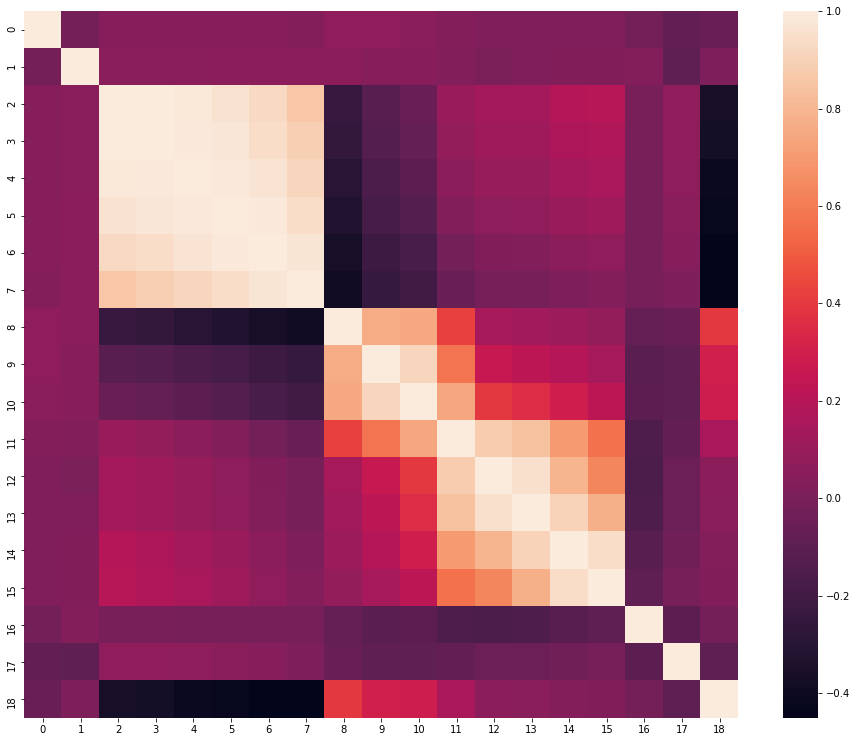

In [16]:
ret_prep.plot_corr(ret_df_train)

In [17]:
ret_df_train_rc = ret_prep.remove_multicollinearity_fit_transform(ret_df_train)

Dropping 3 with vif=1463.549529849921
Dropping 4 with vif=939.062583777379
Dropping 5 with vif=504.52662112905466
Dropping 6 with vif=166.4225174846915
Dropping 16 with vif=153.1239494020561
Dropping 0 with vif=47.53690496400259
Dropping 13 with vif=46.303572036980995
Dropping 11 with vif=34.70279976568829
Dropping 14 with vif=22.580225678536134
Dropping 9 with vif=15.590190681167647
Dropping 2 with vif=15.240102339791974
Dropping 17 with vif=11.372143474686306
7 numerical features left in dataset  0  categorical


In [18]:
ret_df_test_rc = ret_prep.remove_multicollinearity_transform(ret_df_test)

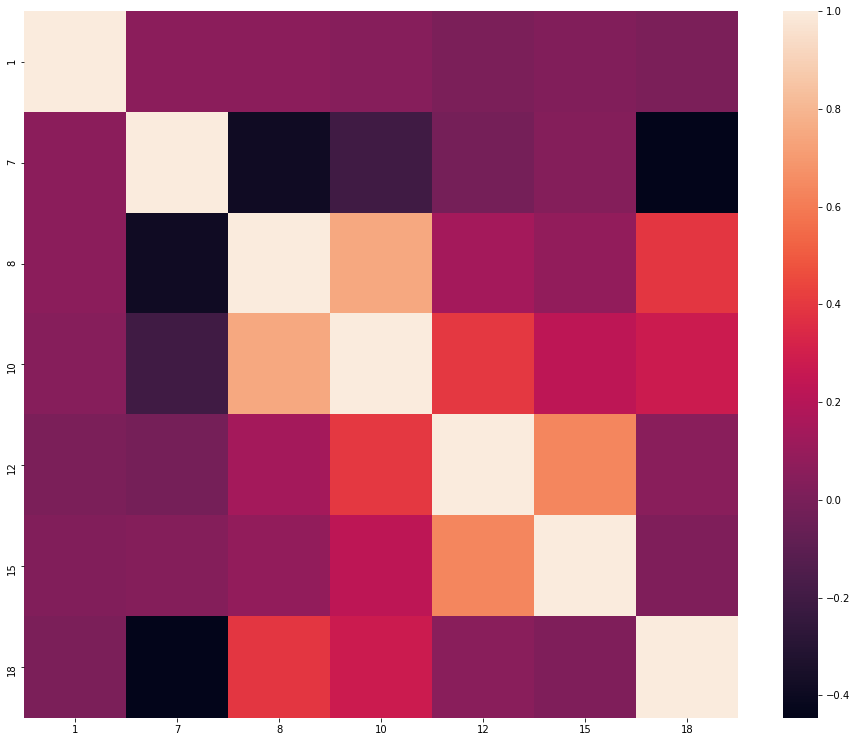

In [19]:
ret_prep.plot_corr(ret_df_train_rc)

#### Results without VIF reduction

In [20]:
model = LogisticRegression(max_iter=1e20)
model.fit(ret_df_train, ret_y_train)
print(ret_df_train.shape)
print('Train acc', model.score(ret_df_train, ret_y_train))
print('Test acc', model.score(ret_df_test, ret_y_test))

(863, 19)
Train acc 0.7566628041714948
Test acc 0.7534722222222222


#### Results with VIF reduction

In [21]:
model = LogisticRegression(max_iter=1e20)
model.fit(ret_df_train_rc, ret_y_train)
print(ret_df_train_rc.shape)
print('Train acc', model.score(ret_df_train_rc, ret_y_train))
print('Test acc', model.score(ret_df_test_rc, ret_y_test))

(863, 7)
Train acc 0.6164542294322132
Test acc 0.6006944444444444


#### Results with VIF reduction and StandardScaler

In [22]:
st_sc = StandardScaler()
ret_df_train_rc_scaled = st_sc.fit_transform(ret_df_train_rc)

model = LogisticRegression(max_iter=1e20)
model.fit(ret_df_train_rc_scaled, ret_y_train)
print(ret_df_train_rc_scaled.shape)
print('Train acc', model.score(ret_df_train_rc_scaled, ret_y_train))
print('Test acc', model.score(st_sc.transform(ret_df_test_rc), ret_y_test))


(863, 7)
Train acc 0.6349942062572422
Test acc 0.5868055555555556


#### Results with feature selection based on correlation matrix

In [23]:
ret_df_train_dc=ret_prep.DeleteCorrelated(ret_df_train)
ret_df_test_dc = ret_df_test.loc[:, ret_df_train_dc.columns]
model = LogisticRegression(max_iter=1e20)
model.fit(ret_df_train_dc, ret_y_train)
print(ret_df_train_dc.shape)
print('Train acc', model.score(ret_df_train_dc, ret_y_train))
print('Test acc', model.score(ret_df_test_dc, ret_y_test))

(863, 8)
Train acc 0.6326767091541136
Test acc 0.625


# 3. Breast Cancer Wisconsin

No missing values. Special treatment: columns `id` and `Unnamed: 32`

In [24]:
wdbc_df=pd.read_csv('data/wdbc.csv')

wdbc_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [25]:
wdbc_df['Unnamed: 32'].any()

False

In [26]:
y_wdbc=wdbc_df['diagnosis']=="M"
X_wdbc=wdbc_df.drop(columns=["id","diagnosis","Unnamed: 32"])

X_wdbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

As we can see all features are non-null numeric type variables. Which means that in this case one-hot-encoding won't be needed. The only things left to do is to remove collinear and multicollinear ones (maybe remove some outliers? from data) and split data into training and testing sets.

Correlation matrix showing that we should probably remove a fair number of variables

In [27]:
prep_wdbc = Preprocessor()

In [28]:
wdbc_train, wdbc_test, y_wdbc_train, y_wdbc_test = prep_wdbc.train_test_split(X_wdbc, y_wdbc)

Removal of variables based only on correlation

In [29]:
X_wdbc_cleaned_corr = prep_wdbc.DeleteCorrelated(wdbc_train,0.8)
X_wdbc_cleaned_corr.columns

Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'smoothness_se', 'compactness_se', 'symmetry_se', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')

Removal of variables using Variance Inflation Factor (VIF)

In [30]:
X_wdbc_cleaned_train = prep_wdbc.remove_multicollinearity_fit_transform(wdbc_train)
X_wdbc_cleaned_train.tail()

Dropping radius_mean with vif=60593.305206508514
Dropping radius_worst with vif=7225.230757528973
Dropping perimeter_mean with vif=3825.0401698216588
Dropping perimeter_worst with vif=692.2132413064913
Dropping fractal_dimension_mean with vif=495.2614041756954
Dropping smoothness_worst with vif=377.9268986506846
Dropping texture_worst with vif=307.9126636877025
Dropping fractal_dimension_worst with vif=193.0763325434795
Dropping symmetry_worst with vif=171.98817109937414
Dropping concavity_mean with vif=150.93827237721513
Dropping concave points_worst with vif=105.55467072177531
Dropping radius_se with vif=98.64264091626333
Dropping smoothness_mean with vif=88.48418009976501
Dropping compactness_worst with vif=86.20659888938694
Dropping area_mean with vif=68.92820098787222
Dropping compactness_mean with vif=50.622596006824374
Dropping perimeter_se with vif=42.4273518898935
Dropping symmetry_mean with vif=37.88343515219424
Dropping texture_mean with vif=23.95293322846434
Dropping compac

,texture_se,area_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,concavity_worst
275,2.2930,48.84,0.014180,0.012670,0.02678,0.003002,0.07153
490,1.1390,18.04,0.005096,0.009410,0.01608,0.002399,0.12300
473,3.6470,35.13,0.007339,0.000000,0.03141,0.003136,0.00000
247,0.4402,16.35,0.005501,0.081580,0.01266,0.007555,0.77270
438,1.6780,29.63,0.005836,0.005812,0.02014,0.002326,0.04753


In [31]:
model = LogisticRegression(max_iter=1e20)
model.fit(X_wdbc_cleaned_train, y_wdbc_train)
print(model.score(X_wdbc_cleaned_train, y_wdbc_train))
model.score(prep_wdbc.remove_multicollinearity_transform(wdbc_test), y_wdbc_test)

0.9272300469483568


0.8531468531468531

## 4. Etherneum frauds

Special treatment columns `Unnamed: 0`, `Index` and `Address`.

In [32]:
eth_prep = Preprocessor()
etherneum_df=pd.read_csv('data/transaction_dataset.csv')

#etherneum_df.head(2).T

In [33]:
to_drop=['Unnamed: 0','Index','Address']
etherneum_df.drop(columns=to_drop,inplace=True)

### Train test split

In [34]:
y_eth=etherneum_df['FLAG']
X_eth=etherneum_df.drop(columns='FLAG')

X_eth_train, X_eth_test, y_eth_train, y_eth_test = eth_prep.train_test_split(X_eth, y_eth)

Columns with null values

In [35]:
for col in X_eth_train.columns:
    if (X_eth_train[col].isna().values.sum()):
        print(col)

 Total ERC20 tnxs
 ERC20 total Ether received
 ERC20 total ether sent
 ERC20 total Ether sent contract
 ERC20 uniq sent addr
 ERC20 uniq rec addr
 ERC20 uniq sent addr.1
 ERC20 uniq rec contract addr
 ERC20 avg time between sent tnx
 ERC20 avg time between rec tnx
 ERC20 avg time between rec 2 tnx
 ERC20 avg time between contract tnx
 ERC20 min val rec
 ERC20 max val rec
 ERC20 avg val rec
 ERC20 min val sent
 ERC20 max val sent
 ERC20 avg val sent
 ERC20 min val sent contract
 ERC20 max val sent contract
 ERC20 avg val sent contract
 ERC20 uniq sent token name
 ERC20 uniq rec token name
 ERC20 most sent token type
 ERC20_most_rec_token_type


Columns which have less than 10 unique values

In [36]:
for col in X_eth_train.columns:
    if(len(X_eth_train[col].unique())<10):
        print(col,X_eth_train[col].unique())

min value sent to contract [0.   0.02 0.01]
max val sent to contract [0.       0.02     0.046029 0.01    ]
avg value sent to contract [0.       0.02     0.023014 0.01    ]
total ether sent contracts [0.         0.02       0.04602871 0.01      ]
 ERC20 uniq sent addr.1 [ 0. nan  1.  2.]
 ERC20 avg time between sent tnx [ 0. nan]
 ERC20 avg time between rec tnx [ 0. nan]
 ERC20 avg time between rec 2 tnx [ 0. nan]
 ERC20 avg time between contract tnx [ 0. nan]
 ERC20 min val sent contract [ 0. nan]
 ERC20 max val sent contract [ 0. nan]
 ERC20 avg val sent contract [ 0. nan]


#### Categorical columns to be One Hot Encoded later

In [37]:
for c in X_eth_train.columns:
    if X_eth_train[c].dtype=='O':
        print(c,len(X_eth_train[c].unique()))

 ERC20 most sent token type 270
 ERC20_most_rec_token_type 413


#### Dealing with missing data
In all columns except for the ones with only 0's and NaN's we'll replace the missing values with the most frequent values in column. In the remaining ones we'll test replacing NaN's with 1 (making it a distinct class) or just dropping the column.

Columns ` ERC20 avg time between sent tnx`, ` ERC20 avg time between rec tnx`, ` ERC20 avg time between rec 2 tnx`, ` ERC20 avg time between contract tnx`, ` ERC20 min val sent contract`, ` ERC20 max val sent contract` and ` ERC20 avg val sent contract` could be either dropped or could be treated as categorical where 0 and NaN are 2 distinct classes.

In [38]:
columns_to_binary=[' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx',
                 ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx',
                 ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']
for col in columns_to_binary:
    #train set
    X_eth_train[col]=X_eth_train[col].fillna(1)
    #test set
    X_eth_test[col]=X_eth_test[col].fillna(1)
#Pomimo obecności SimpleImputera w preprocessorze przy użyciu go było za dużo zabawy z dtype i faktem, że imputer 
#zwraca NumpyArray a nie DataFrame
for col in set(X_eth_train.columns)-set(columns_to_binary):
    #train set
    X_eth_train[col]=X_eth_train[col].fillna(X_eth_train[col].value_counts().index[0])
    #test set
    X_eth_test[col]=X_eth_test[col].fillna(X_eth_train[col].value_counts().index[0])


#### Collinearity detection and VIF transformation

Pair correlations insight:

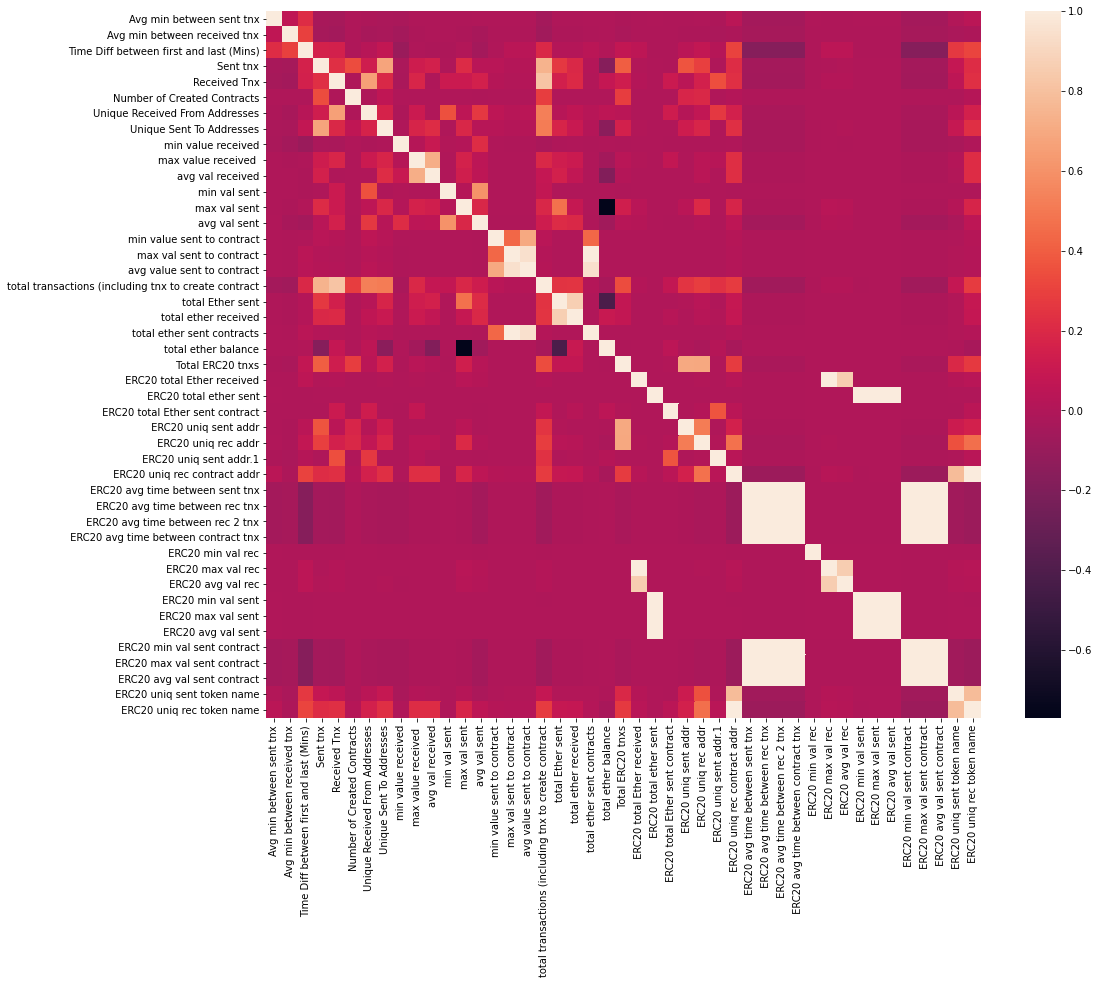

In [39]:
eth_prep.plot_corr(X_eth_train)

In [40]:
X_eth_train_cleaned = eth_prep.remove_multicollinearity_fit_transform(X_eth_train)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping Sent tnx with vif=inf
Dropping total Ether sent with vif=inf
Dropping  ERC20 avg time between sent tnx with vif=inf
Dropping  ERC20 avg time between rec tnx with vif=inf
Dropping  ERC20 avg time between rec 2 tnx with vif=inf
Dropping  ERC20 avg time between contract tnx with vif=inf
Dropping  ERC20 min val sent contract with vif=inf
Dropping  ERC20 max val sent contract with vif=inf
Dropping max val sent to contract with vif=1555702.4471086129
Dropping avg value sent to contract with vif=1190585.232196969
Dropping  ERC20 total Ether received with vif=30694.33865733734
Dropping  ERC20 avg val sent with vif=16098.53475131919
Dropping  ERC20 max val sent with vif=4761.891407838821
Dropping  ERC20 uniq rec token name with vif=1921.5142720315398
Dropping  ERC20 total ether sent with vif=858.2112905695845
Dropping total transactions (including tnx to create contract with vif=10.278278931278123
29 numerical features left in dataset  2  categorical


In [41]:
X_eth_test_cleaned=eth_prep.remove_multicollinearity_transform(X_eth_test)

#### One hot encoding
it is simply impossible to use VIF reduction after One Hot Encoding in this particular case

In [42]:
X_eth_train_ohe = eth_prep.one_hot_encoding_fit_transform(X_eth_train_cleaned)

In [43]:
X_eth_test_ohe = eth_prep.one_hot_encoding_transform(X_eth_test_cleaned)

In [44]:
len(X_eth_train_ohe.columns)

708

#### Results when using only numerical features
without VIF reduction

In [45]:
model = LogisticRegression(max_iter=1e20)
model.fit(X_eth_train.drop(columns=[' ERC20 most sent token type',' ERC20_most_rec_token_type']), y_eth_train)
print(X_eth_train.shape[1])
model.score(X_eth_test.drop(columns=[' ERC20 most sent token type',' ERC20_most_rec_token_type']), y_eth_test)

47


0.8350264120276311

#### Results when using only numerical features
with VIF reduction

In [46]:
model = LogisticRegression(max_iter=1e20)
model.fit(X_eth_train_cleaned.drop(columns=[' ERC20 most sent token type',' ERC20_most_rec_token_type']), y_eth_train)
print(X_eth_train_cleaned.shape[1])
model.score(X_eth_test_cleaned.drop(columns=[' ERC20 most sent token type',' ERC20_most_rec_token_type']), y_eth_test)

31


0.8037383177570093

#### Results when using both numerical and categorical features
with VIF but without rescaling 

In [47]:
model = LogisticRegression(max_iter=1e20)
model.fit(X_eth_train_ohe, y_eth_train)
print(X_eth_train_ohe.shape[1])
model.score(X_eth_test_ohe, y_eth_test)

708


0.8041446566436408

#### Results when using both numerical and categorical features
both using VIF feature reduction as well as rescaling

In [48]:
ss=StandardScaler()
X_train_ohe_rescaled = ss.fit_transform(X_eth_train_ohe)
X_test_ohe_rescaled = ss.transform(X_eth_test_ohe)

model = LogisticRegression(max_iter=1e20)
model.fit(X_train_ohe_rescaled, y_eth_train)
print(X_train_ohe_rescaled.shape[1])
model.score(X_test_ohe_rescaled, y_eth_test)

708


0.9898415278342138